# Stochastic Models in Finance: TP5
By: 
- Adonis JAMAL
- Ayoub EL KBADI
- Fotios KAPOTOS

In [113]:
import numpy as np
from scipy.stats import norm, linregress
from scipy.integrate import quad
from matplotlib import pyplot as plt

In [100]:
# Model values
S0 = 100    # initial stock price
K = 100     # strike price
T = 1.0     # time to maturity in years
r = 0.05    # risk-free rate
lam = 2.0   # speed of mean reversion
theta = 0.04# long-term variance
eta = 0.5   # volatility of volatility
rho = -0.7  # correlation
v0 = 0.04   # initial variance
sigma = 0.2 # volatility
N = 100     # number of time steps
M = 10**4   # number of simulations

In [3]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T) + 1e-10)
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

1. Schéma d'Euler et de Milstein pour l'EDS de Black-Scholes

In [20]:
M_strong = 1000  # number of paths for strong error
M_weak = 500_000   # number of paths for weak error

In [6]:
def simulate_schemes(S0, r, sigma, T, N, M):
    dt = T / N

    # Brownian increments
    dW = np.sqrt(dt) * np.random.randn(M, N)
    W_T = np.sum(dW, axis=1)

    # Exact solution
    S_exact = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)

    # Numerical schemes
    S_euler = np.full(M, S0)
    S_milstein = np.full(M, S0)

    for i in range(N):
        dw_i = dW[:, i]

        # Euler
        S_euler = S_euler * (1 + r * dt + sigma * dw_i)

        # Milstein
        S_milstein = S_milstein * (1 + r * dt + sigma * dw_i + 0.5 * sigma**2 * (dw_i**2 - dt))

    return S_exact, S_euler, S_milstein

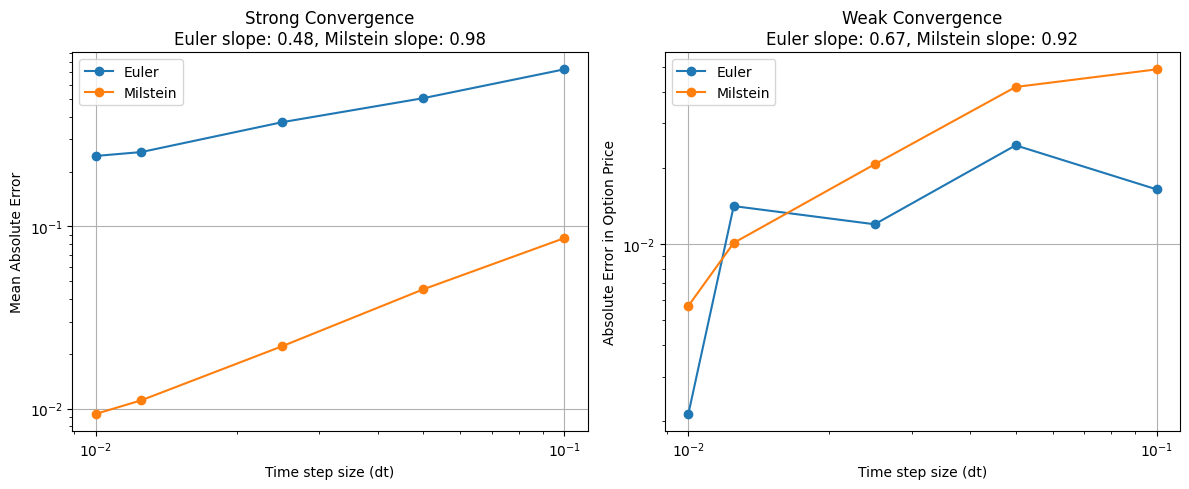

In [101]:
N_steps_list = [10, 20, 40, 80, 100]
dt_list = [T / N for N in N_steps_list]

strong_errors_euler = []
strong_errors_milstein = []
weak_errors_euler = []
weak_errors_milstein = []

bs_price = black_scholes_call(S0, K, T, r, sigma)

for N in N_steps_list:
    # Strong convergence
    S_exact_strong, S_euler_strong, S_milstein_strong = simulate_schemes(S0, r, sigma, T, N, M_strong)
    
    # Strong error
    strong_errors_euler.append(np.mean(np.abs(S_exact_strong - S_euler_strong)))
    strong_errors_milstein.append(np.mean(np.abs(S_exact_strong - S_milstein_strong)))

    # Weak convergence
    S_exact_weak, S_euler_weak, S_milstein_weak = simulate_schemes(S0, r, sigma, T, N, M_weak)

    # Call option payoffs
    payoff_euler = np.maximum(S_euler_weak - K, 0) * np.exp(-r * T)
    payoff_milstein = np.maximum(S_milstein_weak - K, 0) * np.exp(-r * T)

    # Weak error
    weak_errors_euler.append(np.abs(np.mean(payoff_euler) - bs_price))
    weak_errors_milstein.append(np.abs(np.mean(payoff_milstein) - bs_price))

# Plots
plt.figure(figsize=(12, 5))

# Strong convergence plot
plt.subplot(1, 2, 1)
plt.loglog(dt_list, strong_errors_euler, label='Euler', marker='o')
plt.loglog(dt_list, strong_errors_milstein, label='Milstein', marker='o')

slope_euler, intercept_euler, _, _, _ = linregress(np.log(dt_list), np.log(strong_errors_euler))
slope_milstein, intercept_milstein, _, _, _ = linregress(np.log(dt_list), np.log(strong_errors_milstein))

plt.title(f"Strong Convergence\nEuler slope: {slope_euler:.2f}, Milstein slope: {slope_milstein:.2f}")
plt.xlabel('Time step size (dt)')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# Weak convergence plot
plt.subplot(1, 2, 2)
plt.loglog(dt_list, weak_errors_euler, label='Euler', marker='o')
plt.loglog(dt_list, weak_errors_milstein, label='Milstein', marker='o')

slope_euler_weak, intercept_euler_weak, _, _, _ = linregress(np.log(dt_list), np.log(weak_errors_euler))
slope_milstein_weak, intercept_milstein_weak, _, _, _ = linregress(np.log(dt_list), np.log(weak_errors_milstein))

plt.title(f"Weak Convergence\nEuler slope: {slope_euler_weak:.2f}, Milstein slope: {slope_milstein_weak:.2f}")
plt.xlabel('Time step size (dt)')
plt.ylabel('Absolute Error in Option Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Pour la convergence forte, on obtient une pente de 0.5 pour le schéma d'Euler et une pente de 1 pour le schéma de Milstein, ce qui est conforme aux théories établies. Cela signifie que le schéma d'Euler divise l'erreur par 2 quand le pas de temps est divisé par 4, tandis que le schéma de Milstein divise l'erreur par 2 quand le pas de temps est divisé par 2. L'erreur est donc réduite plus rapidement avec le schéma de Milstein grâce au terme d'Itô supplémentaire.

Pour la convergence faible, bien qu'on puisse s'attendre à une pente de 1 pour les deux schémas, on remarque que l'on obtient une courbe en zigzag. Cela peut être dû à l'erreur statistique (variance) liée au Monte Carlo, qui est proportionnelle à $\frac{1}{\sqrt{M}}$ et qui ici domine l'erreur de discrétisation (biais). Pour améliorer la précision, on pourrait augmenter le nombre de simulations $M$ ou utiliser des techniques de réduction de variance. Bien qu'on soit déjà à $M = 500,000$, cela s'avère insuffisant pour obtenir une estimation précise de l'erreur faible.

2. Modèle de Heston par Monte Carlo

In [102]:
def Heston_model(S0, K, T, r, lam, theta, eta, rho, v0, N, M):
    dt = T / N

    # Brownian increments
    G1 = np.random.randn(M, N)
    G2 = np.random.randn(M, N)
    W1 = G1
    W2 = rho * G1 + np.sqrt(1 - rho**2) * G2

    # Initialize arrays
    S = np.full(M, S0)
    V = np.full(M, v0)

    # Euler scheme
    for i in range(N):
        # Update Price
        S_next = S + r * S * dt + np.sqrt(np.maximum(V, 0)) * S * np.sqrt(dt) * W1[:, i]

        # Update Variance
        V_next = V + lam * (theta - np.maximum(V, 0)) * dt + eta * np.sqrt(np.maximum(V, 0)) * np.sqrt(dt) * W2[:, i]

        S, V = S_next, V_next

    # Call option payoff
    payoff = np.maximum(S - K, 0)
    price = np.exp(-r * T) * np.mean(payoff)
    return price

In [103]:
heston_price = Heston_model(S0, K, T, r, lam, theta, eta, rho, v0, N, M)
print(f"Heston Model Call Option Price: {heston_price:.4f}")

bs_price = black_scholes_call(S0, K, T, r, np.sqrt(v0))
print(f"Black-Scholes Call Option Price (with initial vol): {bs_price:.4f}")

Heston Model Call Option Price: 10.2599
Black-Scholes Call Option Price (with initial vol): 10.4506


3. Calcul de la volatilité implicite par dichotomie

In [104]:
def implied_volatility_dichotomy(market_price, S, K, T, r, tol=1e-6, max_iter=100):
    # Initial bounds, avoid division by zero
    a, b = 0.0, 1.0 - 1e-6

    for _ in range(max_iter):
        x_mid = (a + b) / 2

        sigma_mid = x_mid / (1 - x_mid)

        # Black-Scholes price at mid volatility
        price_mid = black_scholes_call(S, K, T, r, sigma_mid)

        if price_mid < market_price: a = x_mid
        else: b = x_mid

        if abs(price_mid - market_price) < tol: return sigma_mid

    return (a + b) / 2 / (1 - (a + b) / 2)

In [105]:
implied_vol = implied_volatility_dichotomy(heston_price, S0, K, T, r)
print(f"Implied Volatility from Heston Price: {implied_vol:.4f}")

Implied Volatility from Heston Price: 0.1949


La fonction BlackScholes($\sigma$) est strictement croissante par rapport à $\sigma$ (Vega positif). Ainsi, cela garantit l'existence et l'unicité de la solution à l'équation BlackScholes($\sigma$) = Prix du call.

La transformation permet de restreindre l'intervalle de recherche de la volatilité implicite entre 0 et 1, ce qui facilite la convergence de la méthode de dichotomie tout en couvrant tout l'espace des volatilités (si $x \to 0$, alors $\sigma \to 0$, si $x \to 1$, alors $\sigma \to +\infty$).

4. Smile de volatilité dans le modèle de Heston

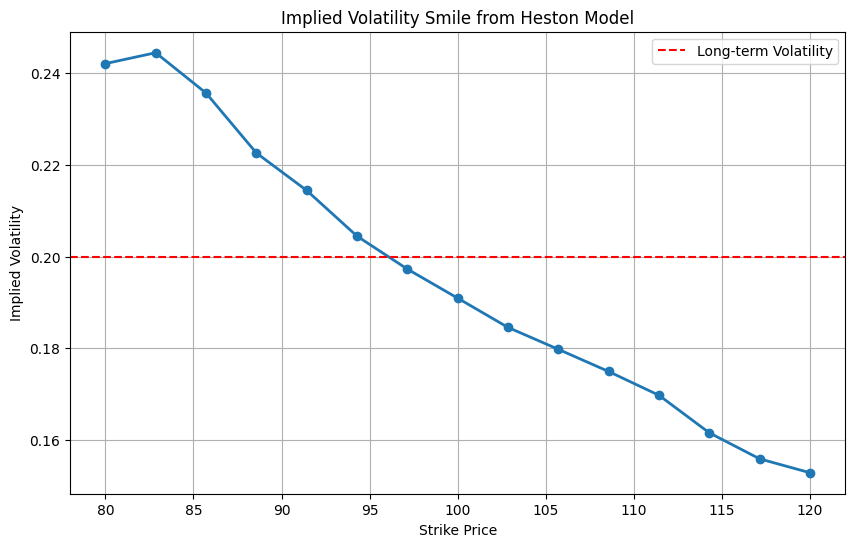

In [ ]:
strikes = np.linspace(80, 120, 15)
implied_vols = []

for K_val in strikes:
    heston_price = Heston_model(S0, K_val, T, r, lam, theta, eta, rho, v0, N, M)
    implied_vol = implied_volatility_dichotomy(heston_price, S0, K_val, T, r)
    implied_vols.append(implied_vol)

# Smile plot
plt.figure(figsize=(10, 6))
plt.plot(strikes, implied_vols, marker='o', linewidth=2, label='Implied Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Smile from Heston Model')
plt.grid(True)

long_term_vol = np.sqrt(theta)
plt.axhline(y=long_term_vol, color='r', linestyle='--', label='Long-term Volatility')
plt.legend()

plt.show()

On observe une courbe décroissante de la volatilité implicite en fonction du strike, ce qui est cohérent avec le phénomène de smile de volatilité (skew négatif). 

Les strikes faibles présentent une volatilité implicite plus élevée, reflétant la prime de risque associée aux options in-the-money. En effet, c'est l'effet de levier (panic selling) qui fait que les investisseurs sont prêts à payer plus pour se protéger contre les baisses importantes du sous-jacent.

La volatilité de la volatilité (eta) crée un risque supplémentaire qui se manifeste par des queues plus épaisses (des événements extrêmes plus probables) que pour une distribution normale, que le modèle de Heston arrive bien à capturer.

5. Déformation du smile de volatilité en fonction des paramètres de la dynamique de volatilité

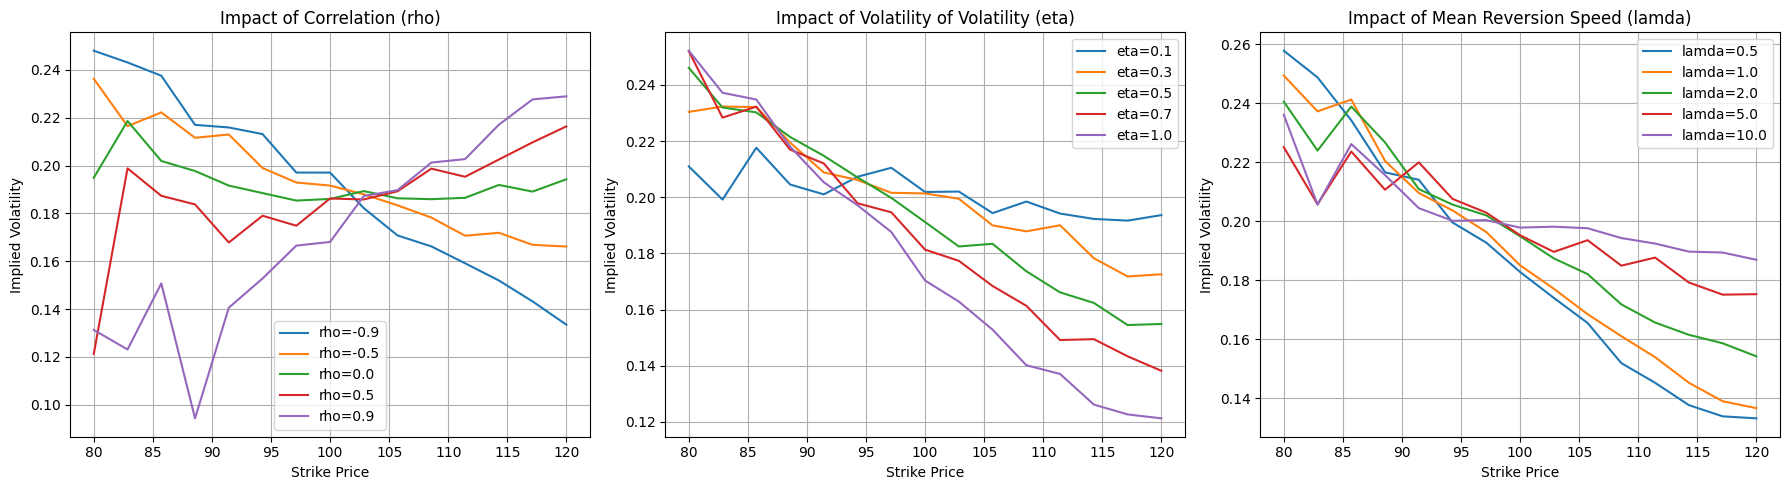

In [112]:
strikes = np.linspace(80, 120, 15)

def get_smile_curve(strikes, S0, T, r, lam, theta, eta, rho, v0, N, M):
    implied_vols = []
    for K_val in strikes:
        heston_price = Heston_model(S0, K_val, T, r, lam, theta, eta, rho, v0, N, M)
        implied_vol = implied_volatility_dichotomy(heston_price, S0, K_val, T, r)
        implied_vols.append(implied_vol)
    return implied_vols

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# rho impact (correlation)
rhos = [-0.9, -0.5, 0.0, 0.5, 0.9]
ax = axes[0]
for rho_val in rhos:
    implied_vols = get_smile_curve(strikes, S0, T, r, lam, theta, eta, rho_val, v0, N, M)
    ax.plot(strikes, implied_vols, label=f'rho={rho_val}')

ax.set_title('Impact of Correlation (rho)')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Implied Volatility')
ax.legend()
ax.grid(True)

# eta impact (vol of vol)
etas = [0.1, 0.3, 0.5, 0.7, 1.0]
ax = axes[1]
for eta_val in etas:
    implied_vols = get_smile_curve(strikes, S0, T, r, lam, theta, eta_val, rho, v0, N, M)
    ax.plot(strikes, implied_vols, label=f'eta={eta_val}')

ax.set_title('Impact of Volatility of Volatility (eta)')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Implied Volatility')
ax.legend()
ax.grid(True)

# lamda impact (mean reversion speed)
lambdas = [0.5, 1.0, 2.0, 5.0, 10.0]
ax = axes[2]
for lam_val in lambdas:
    implied_vols = get_smile_curve(strikes, S0, T, r, lam_val, theta, eta, rho, v0, N, M)
    ax.plot(strikes, implied_vols, label=f'lamda={lam_val}')

ax.set_title('Impact of Mean Reversion Speed (lamda)')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Implied Volatility')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()
    

La corrélation $\rho$ influence fortement la pente du smile de volatilité. Une corrélation négative accentue le skew négatif (courbe décroissante), la volatilité des strikes bas est plus élevée. Inversement, une corrélation positive donne un skew positif (courbe croissante). Pour $\rho = 0$, le smile est symétrique (en forme de parabole) autour du strike. Sur le marché actions, $\rho$ est généralement négatif, reflétant l'effet de levier. Quand le prix de l'actif baisse, la volatilité tend à augmenter. Les investisseurs paient cher les puts OTM, ce qui monte leur volatilité implicite.

La volatilité de la volatilité $\eta$ affecte la convexité du smile. Une $\eta$ plus élevée augmente la convexité, rendant le smile plus prononcé. Pour $\eta = 0$, le smile est plat, similaire au modèle de Black-Scholes avec volatilité constante. Une $\eta$ élevée donne une courbe très convexe. En pratique, cela signifie que la volatilité peut atteindre des niveaux extrêmes, ce qui est observé lors de périodes de forte turbulence sur les marchés financiers. Les options loin de la monnaie deviennent plus chères.

La vitesse de réversion $\lambda$ influence la rapidité avec laquelle la volatilité revient à son niveau moyen $\theta$. Ce paramètre contrôle la rigidité du modèle. Plus $\lambda$ est grand, plus la volatilité est contrainte autour de $\theta$, ce qui tend à aplatir le smile. Inversement, une $\lambda$ faible permet à la volatilité de s'écarter davantage de $\theta$, accentuant le smile. En pratique, une $\lambda$ élevée signifie que les chocs de volatilité sont de courte durée, tandis qu'une $\lambda$ faible indique que les périodes de haute ou basse volatilité peuvent persister plus longtemps.

6. (pour aller plus loin) Smiles par la méthode de Fourier